In [2]:
import numpy as np
import scipy as sp
from SimPEG import Mesh, Maps, Models, Utils
import matplotlib.pyplot as plt
from SimPEG.Utils import mkvc


C:\Users\DominiqueFournier\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


(<matplotlib.collections.QuadMesh at 0x1e947f950b8>,
 <matplotlib.lines.Line2D at 0x1e947f0dba8>)

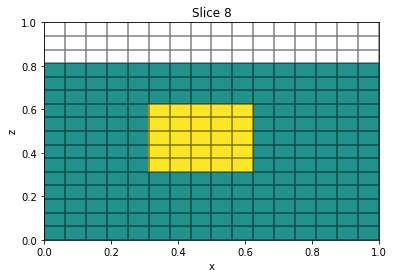

In [16]:
meshTree = Mesh.TreeMesh([16, 16, 16])
meshTree.refine(3, finalize=False)
meshTree.insert_cells(np.c_[0.2,0.2,0.1], 4, finalize=True)

meshTensor = Mesh.TensorMesh([16, 16, 16])
# meshTensor.refine(3, finalize=True)

actv_b = np.ones(meshTensor.nC, dtype='bool')
actv_b[meshTensor.gridCC[:,2]>0.8] = False

# Create a model
model = np.ones(meshTensor.nC) * 1

# Insert a block
ind = Utils.ModelBuilder.getIndicesBlock(np.r_[0.3,0.3,0.3], np.r_[0.6,0.6,0.6], meshTensor.gridCC)
model[ind] = 2
model[actv_b==False] = np.nan

meshTensor.plotSlice(model, ind=int(np.searchsorted(meshTensor.vectorCCy,0.5)), normal='Y', grid=True, clim=[0, 2])

In [18]:
class Tile(Maps.IdentityMap):
    """
        Mapping for tiled inversion
    """

    nCell = 26  # Number of neighbors to use in averaging
    tol = 1e-8  # Tolerance to avoid zero division
    nBlock = 1

    def __init__(self, *args, **kwargs):

        assert len(args) == 2, ('Mapping requires a tuple' +
                                '(MeshGlobal, ActiveGlobal),' +
                                '(MeshLocal, ActiveLocal)')
        super(Tile, self).__init__(**kwargs)
        # check if tree in kwargs
        if 'tree' in kwargs.keys():   # kwargs is a dict
            tree = kwargs.pop('tree')

            assert isinstance(tree, cKDTree), ('Tree input must be a cKDTRee')
            self._tree = tree

        self.meshGlobal = args[0][0]
        self.actvGlobal = args[0][1]

        if not isinstance(self.actvGlobal, bool):
            temp = np.zeros(self.meshGlobal.nC, dtype='bool')
            temp[self.actvGlobal] = True
            self.actvGlobal = temp

        self.meshLocal = args[1][0]
        self.activeLocal = args[1][1]

        # if not isinstance(self.activeLocal, bool):
        #     temp = np.zeros(self.meshLocal.nC, dtype='bool')
        #     temp[self.activeLocal] = True
        #     self.activeLocal = temp

        if self.nCell > self.meshGlobal.nC:
            self.nCell = self.meshGlobal.nC

        self.index = np.ones(self.actvGlobal.sum(), dtype='bool')
        self.P

    @property
    def tree(self):
        """
            Create cKDTree structure for given global mesh
        """
        if getattr(self, '_tree', None) is None:

            # if self.meshGlobal.dim == 1:
            #     ccMat = np.c_[self.meshGlobal.gridCC[self.actvGlobal, 0]]
            # elif self.meshGlobal.dim == 2:
            #     ccMat = np.c_[self.meshGlobal.gridCC[self.actvGlobal, 0],
            #                   self.meshGlobal.gridCC[self.actvGlobal, 1]]
            # elif self.meshGlobal.dim == 3:
            #     ccMat = np.c_[self.meshGlobal.gridCC[self.actvGlobal, 0],
            #                   self.meshGlobal.gridCC[self.actvGlobal, 1],
            #                   self.meshGlobal.gridCC[self.actvGlobal, 2]]

            self._tree = cKDTree(self.meshGlobal.gridCC[self.actvGlobal, :])

        return self._tree

    @property
    def activeLocal(self):
        """This is the activeLocal of the actvGlobal used in the global problem."""
        return getattr(self, '_activeLocal', None)

    @activeLocal.setter
    def activeLocal(self, activeLocal):

        if not isinstance(activeLocal, bool):
            temp = np.zeros(self.meshLocal.nC, dtype='bool')
            temp[activeLocal] = True
            activeLocal = temp

        self._activeLocal = activeLocal


    @property
    def index(self):
        """This is the index of the actvGlobal used in the global problem."""
        return getattr(self, '_index', None)

    @index.setter
    def index(self, index):
        if getattr(self, '_index', None) is not None:
            self._S = None

        if not isinstance(index, bool):
            temp = np.zeros(self.actvGlobal.sum(), dtype='bool')
            temp[index] = True
            index = temp

        self._nP = index.sum()
        self._index = index

    @property
    def S(self):
        """
            Create sub-selection matrix in case where the global
            mesh is not touched by all sub meshes
        """
        if getattr(self, '_S', None) is None:

            nP = self.actvGlobal.sum()
            nI = self.index.sum()
            assert (nI <= nP), (
                'maximum index must be less than {}'.format(nP))

            # sparse projection matrix
            S = sp.csr_matrix(
                (np.ones(nI), (np.where(self.index)[0], range(nI))), shape=(nP, nI)
            )

            self._S = S
        return self._S

    @property
    def P(self):
        """
            Set the projection matrix with partial volumes
        """
        if getattr(self, '_P', None) is None:

            if self.meshLocal._meshType == "TREE":

                actvIndGlobal = np.where(self.actvGlobal)[0].tolist()

                indL = self.meshLocal._get_containing_cell_indexes(self.meshGlobal.gridCC)

                full = np.c_[indL, np.arange(self.meshGlobal.nC)]
                # Create new index based on unique active
                # [ua, ind] = np.unique(indL, return_index=True)

                check = np.where(self.meshLocal.vol[indL] < self.meshGlobal.vol)[0].tolist()

                # Reverse inside global to local
                indG = self.meshGlobal._get_containing_cell_indexes(self.meshLocal.gridCC)

                model = np.zeros(self.meshLocal.nC)

                rows = []
                for ind in check:

                    if ind in actvIndGlobal:
                        indAdd = np.where(ind == indG)[0]
                        rows += [np.c_[indAdd, np.ones_like(indAdd)*ind]]
                        # model[indAdd] = 0.5

                # indL = indL[actv]
                if len(rows) > 0:
                    full = np.r_[full[actvIndGlobal, :], np.vstack(rows)]
                else:
                    full = full[actvIndGlobal, :]

                # model[full[:,0]]=0.5

                actvIndLocal = np.unique(full[:, 0])

                full = np.c_[np.searchsorted(actvIndLocal, full[:, 0]), np.searchsorted(actvIndGlobal, full[:, 1])]

                activeLocal = np.zeros(self.meshLocal.nC, dtype='bool')
                activeLocal[actvIndLocal] = True

                self.activeLocal = activeLocal

            else:
                indx = self.getTreeIndex(self.tree, self.meshLocal, self.activeLocal)
                local2Global = np.c_[np.kron(np.ones(self.nCell), np.asarray(range(self.activeLocal.sum()))).astype('int'), mkvc(indx)]

                tree = cKDTree(self.meshLocal.gridCC[self.activeLocal, :])
                r, ind = tree.query(self.meshGlobal.gridCC[self.actvGlobal], k=self.nCell)
                global2Local = np.c_[np.kron(np.ones(self.nCell), np.asarray(range(self.actvGlobal.sum()))).astype('int'), mkvc(ind)]

                full = np.unique(np.vstack([local2Global, global2Local[:, [1, 0]]]), axis=0)

            # Free up memory
            self._tree = None
            tree = None

            # Get the node coordinates (bottom-SW) and (top-NE) of cells
            # in the global and local mesh
            global_bsw, global_tne = self.getNodeExtent(self.meshGlobal,
                                                        self.actvGlobal)

            local_bsw, local_tne = self.getNodeExtent(self.meshLocal,
                                                      self.activeLocal)

            nactv = full.shape[0]

            # Compute intersecting cell volumes
            if self.meshLocal.dim == 1:

                dV = np.max(
                    [(np.min(
                        [global_tne[full[:, 1]],
                         local_tne[full[:, 0]]], axis=0
                      ) -
                      np.max(
                        [global_bsw[full[:, 1]],
                         local_bsw[full[:, 0]]], axis=0)
                      ), np.zeros(nactv)
                     ], axis=0
                )

            elif self.meshLocal.dim >= 2:

                dV = np.max(
                    [(np.min(
                        [global_tne[full[:, 1], 0],
                         local_tne[full[:, 0], 0]], axis=0
                       ) -
                      np.max(
                        [global_bsw[full[:, 1], 0],
                         local_bsw[full[:, 0], 0]], axis=0)
                      ), np.zeros(nactv)], axis=0
                    )

                dV *= np.max([(np.min([global_tne[full[:, 1], 1], local_tne[full[:, 0], 1]],
                                      axis=0) -
                               np.max([global_bsw[full[:, 1], 1], local_bsw[full[:, 0], 1]],
                                      axis=0)),
                              np.zeros(nactv)], axis=0)

            if self.meshLocal.dim == 3:

                dV *= np.max([(np.min([global_tne[full[:, 1], 2], local_tne[full[:, 0], 2]],
                                      axis=0) -
                               np.max([global_bsw[full[:, 1], 2], local_bsw[full[:, 0], 2]],
                                      axis=0)),
                              np.zeros(nactv)], axis=0)

            # Select only cells with non-zero intersecting volumes
            nzV = dV > 0

            self.V = dV[nzV]

            P = sp.csr_matrix((self.V, (full[nzV, 0], full[nzV, 1])),
                              shape=(self.activeLocal.sum(), self.actvGlobal.sum()))

            sumRow = Utils.mkvc(np.sum(P, axis=1) + self.tol)

            self.scaleJ = sp.block_diag([
                Utils.sdiag(sumRow/self.meshLocal.vol[self.activeLocal])
                for ii in range(self.nBlock)])

            self._P = sp.block_diag([
                Utils.sdiag(1./sumRow) * P * self.S
                for ii in range(self.nBlock)])

            self._shape = int(self.activeLocal.sum()*self.nBlock), int(self.actvGlobal.sum()*self.nBlock)

        return self._P

    def getTreeIndex(self, tree, mesh, actvCell):
        """
            Querry the KDTree for nearest cells
        """

        # if self.meshGlobal.dim == 1:

        d, indx = tree.query(mesh.gridCC[actvCell, :],
                             k=self.nCell)

        # elif self.meshGlobal.dim == 2:
        #     d, indx = tree.query(np.c_[mesh.gridCC[actvCell, 0],
        #                                mesh.gridCC[actvCell, 1]],
        #                          k=self.nCell)
        # elif self.meshGlobal.dim == 3:
        #     d, indx = tree.query(np.c_[mesh.gridCC[actvCell, 0],
        #                                mesh.gridCC[actvCell, 1],
        #                                mesh.gridCC[actvCell, 2]],
        #                          k=self.nCell)
        return indx

    def getNodeExtent(self, mesh, actvCell):

        bsw = mesh.gridCC - mesh.h_gridded/2.
        tne = mesh.gridCC + mesh.h_gridded/2.

        # Return only active set
        return bsw[actvCell], tne[actvCell]

    def _transform(self, m):
        return self.P * m

    @property
    def shape(self):
        """
        Shape of the matrix operation (number of indices x nP)
        """
        return self.P.shape

    def deriv(self, m, v=None):
        """
            :param numpy.array m: model
            :rtype: scipy.sparse.csr_matrix
            :return: derivative of transformed model
        """

        self.P
        if v is not None:
            return self.scaleJ * self.P * v
        return self.scaleJ * self.P

In [5]:
check


NameError: name 'check' is not defined

In [6]:
indL = mesh_a._get_containing_cell_indexes(mesh_b.gridCC[actv_b])

# indG = mesh_b._get_containing_cell_indexes(mesh_a.gridCC)
#

# Create new index based on unique active
[ua, ind] = np.unique(indL, return_index=True)
newCellInd = np.arange(ua.shape[0])

activeLocal = np.zeros(mesh_a.nC, dtype='bool')
activeLocal[ua] = True

# activeLocal = activeLocal

# Transfer old index to new
indL = np.searchsorted(ua, indL)

full = np.c_[indL, np.arange(actv_b.sum())]



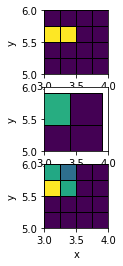

In [7]:
axs = plt.subplot(3,1,1)
mesh_a.plotImage(m, grid='on', ax=axs, clim=[0,2])
axs.set_xlim([3,4])
axs.set_ylim([5,6])
axs.set_aspect('equal')


axs = plt.subplot(3,1,2)
mesh_b.plotImage(mout, grid='on', ax=axs, clim=[0,2])
axs.set_xlim([3,4])
axs.set_ylim([5,6])
axs.set_aspect('equal')

axs = plt.subplot(3,1,3)
mesh_a.plotImage(mDeriv, grid='on', ax=axs)


axs.set_xlim([3,4])
axs.set_ylim([5,6])

axs.set_aspect('equal')

plt.show()